In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Display of the dataset for reference
accidents = pd.read_csv('accident.csv')
accidents.head(10000000)



,ACCIDENT_NO,ACCIDENT_DATE,ACCIDENT_TIME,ACCIDENT_TYPE,ACCIDENT_TYPE_DESC,DAY_OF_WEEK,DAY_WEEK_DESC,DCA_CODE,DCA_DESC,LIGHT_CONDITION,...,NO_PERSONS_INJ_2,NO_PERSONS_INJ_3,NO_PERSONS_NOT_INJ,NO_PERSONS,POLICE_ATTEND,ROAD_GEOMETRY,ROAD_GEOMETRY_DESC,SEVERITY,SPEED_ZONE,RMA
0,T20120000046,2012-01-01,16:25:00,2,Struck Pedestrian,1,Sunday,102,FAR SIDE. PED HIT BY VEHICLE FROM THE LEFT,1,...,0,1,1,2,1,2,T intersection,3,60,Arterial Other
1,T20120000062,2012-01-01,18:00:00,4,Collision with a fixed object,1,Sunday,173,RIGHT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE,1,...,1,0,0,1,1,5,Not at intersection,2,100,NaN
2,T20120000060,2012-01-01,19:40:00,6,Vehicle overturned (no collision),1,Sunday,184,OUT OF CONTROL ON CARRIAGEWAY (ON BEND),1,...,1,0,0,1,1,2,T intersection,2,60,Local Road
3,T20120000009,2012-01-01,02:25:00,4,Collision with a fixed object,1,Sunday,171,LEFT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE,5,...,0,2,0,2,1,5,Not at intersection,3,100,Arterial Other
4,T20120000059,2012-01-01,18:05:00,4,Collision with a fixed object,1,Sunday,171,LEFT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE,1,...,2,0,0,2,1,5,Not at intersection,2,100,Arterial Highway
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178690,T20240016513,2024-06-30,07:15:00,1,Collision with vehicle,0,Sunday,130,REAR END(VEHICLES IN SAME LANE),2,...,0,1,1,2,2,1,Cross intersection,3,80,Arterial Highway
178691,T20240016557,2024-06-30,16:30:00,4,Collision with a fixed object,1,Sunday,179,OTHER ACCIDENTS-OFF STRAIGHT NOT INCLUDED IN D...,2,...,0,1,1,2,2,5,Not at intersection,3,100,Freeway
178692,T20240016524,2024-06-30,12:15:00,1,Collision with vehicle,0,Sunday,113,RIGHT NEAR (INTERSECTIONS ONLY),1,...,0,1,1,2,1,2,T intersection,3,60,Local Road
178693,T20240016563,2024-06-30,13:00:00,4,Collision with a fixed object,1,Sunday,171,LEFT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE,1,...,2,0,0,3,1,5,Not at intersection,1,70,Arterial Other


In [3]:
# Creation of accident severity index (Credit to liam)
def calculate_accident_severity(accident_row):
    """
    A function that takes in a row of the dataframe constructed from the accident.csv file and returns the severity
    of the accident, calculated from a formula involving the number of deaths, serious injuries, minor injuries, and
    proportion of people involved in the accident who got injured.
    """
    # accident.csv column names as constants
    NO_PERSONS_KILLED = "NO_PERSONS_KILLED"
    NO_SERIOUS_INJ = "NO_PERSONS_INJ_2"
    NO_MINOR_INJ = "NO_PERSONS_INJ_3"
    NO_PERSONS = "NO_PERSONS"

    # constants for this function
    DEATH_WEIGHT = 2.5
    SERIOUS_INJ_WEIGHT = 1
    MINOR_INJ_WEIGHT = 0.3
    PROPORTION_AFFECTED_WEIGHT = 1
    MAX_SEVERITY = 10

    # how many people died, were seriously injured etc.
    death_count = accident_row[NO_PERSONS_KILLED]
    serious_inj_count = accident_row[NO_SERIOUS_INJ]
    minor_inj_count = accident_row[NO_MINOR_INJ]
    total = accident_row[NO_PERSONS]

    if total == 0:
        proportion_affected = 0
    else:
        proportion_affected = (
                                      death_count + serious_inj_count + minor_inj_count
                              ) / total

    # formula for the severity
    severity = (
            death_count * DEATH_WEIGHT
            + serious_inj_count * SERIOUS_INJ_WEIGHT
            + minor_inj_count * MINOR_INJ_WEIGHT
            + proportion_affected * PROPORTION_AFFECTED_WEIGHT
    )
    # rounds it to 1 decimal place and caps it at 10.0
    severity = round(min(severity, MAX_SEVERITY), 1)
    return severity


accidents["SEVERITY_INDEX"] = accidents.apply(calculate_accident_severity, axis="columns")

In [4]:
vehicle = pd.read_csv('vehicle.csv')
vehicle

,ACCIDENT_NO,VEHICLE_ID,VEHICLE_YEAR_MANUF,VEHICLE_DCA_CODE,INITIAL_DIRECTION,ROAD_SURFACE_TYPE,ROAD_SURFACE_TYPE_DESC,REG_STATE,VEHICLE_BODY_STYLE,VEHICLE_MAKE,...,TRAILER_TYPE,VEHICLE_COLOUR_1,VEHICLE_COLOUR_2,CAUGHT_FIRE,INITIAL_IMPACT,LAMPS,LEVEL_OF_DAMAGE,TOWED_AWAY_FLAG,TRAFFIC_CONTROL,TRAFFIC_CONTROL_DESC
0,T20120000009,A,1996.0,1.0,E,1.0,Paved,V,SEDAN,HOLDEN,...,H,WHI,ZZ,2.0,1,1.0,5,1.0,0.0,No control
1,T20120000012,A,2002.0,1.0,W,1.0,Paved,V,SEDAN,HOLDEN,...,H,BLU,ZZ,2.0,1,1.0,2,2.0,1.0,Stop-go lights
2,T20120000012,B,1988.0,2.0,S,1.0,Paved,V,SEDAN,TOYOTA,...,H,WHI,ZZ,2.0,5,9.0,4,1.0,1.0,Stop-go lights
3,T20120000013,A,1997.0,1.0,N,1.0,Paved,V,SEDAN,MITSUB,...,H,GLD,ZZ,2.0,5,1.0,4,1.0,0.0,No control
4,T20120000013,B,2010.0,2.0,N,1.0,Paved,V,WAGON,TOYOTA,...,H,BLK,ZZ,2.0,4,2.0,4,2.0,0.0,No control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325884,T20250001671,A,2015.0,2.0,NW,1.0,Paved,V,WAGON,B M W,...,H,WHI,ZZ,2.0,F,2.0,2,9.0,0.0,No control
325885,T20250001671,B,0.0,1.0,SE,1.0,Paved,Z,SEDAN,UNKN,...,H,ZZ,ZZ,9.0,9,9.0,9,9.0,0.0,No control
325886,T20250001949,A,2010.0,1.0,NE,1.0,Paved,V,SEDAN,HOLDEN,...,H,GRY,ZZ,2.0,F,2.0,9,9.0,0.0,No control
325887,T20250002210,A,2021.0,1.0,NW,1.0,Paved,V,WAGON,MITSUB,...,H,SIL,ZZ,2.0,F,0.0,1,2.0,1.0,Stop-go lights


In [5]:
# Inner join only includes vehicles that have been involved in accidents
'''
I know that vehicles.csv only populates vehicles that have been in accidents
but this prevents any potential vehicles without a matching accident number
and potential accidents without a matching vehicle number in to connect
the respective csvs properly hence inner join is best
'''
merged_va = pd.merge(vehicle, accidents, on='ACCIDENT_NO', how='inner')
print(len(merged_va))
merged_va.head(1000)




325889


,ACCIDENT_NO,VEHICLE_ID,VEHICLE_YEAR_MANUF,VEHICLE_DCA_CODE,INITIAL_DIRECTION,ROAD_SURFACE_TYPE,ROAD_SURFACE_TYPE_DESC,REG_STATE,VEHICLE_BODY_STYLE,VEHICLE_MAKE,...,NO_PERSONS_INJ_3,NO_PERSONS_NOT_INJ,NO_PERSONS,POLICE_ATTEND,ROAD_GEOMETRY,ROAD_GEOMETRY_DESC,SEVERITY,SPEED_ZONE,RMA,SEVERITY_INDEX
0,T20120000009,A,1996.0,1.0,E,1.0,Paved,V,SEDAN,HOLDEN,...,2,0,2,1,5,Not at intersection,3,100,Arterial Other,1.6
1,T20120000012,A,2002.0,1.0,W,1.0,Paved,V,SEDAN,HOLDEN,...,0,2,3,1,1,Cross intersection,2,80,NaN,1.3
2,T20120000012,B,1988.0,2.0,S,1.0,Paved,V,SEDAN,TOYOTA,...,0,2,3,1,1,Cross intersection,2,80,NaN,1.3
3,T20120000013,A,1997.0,1.0,N,1.0,Paved,V,SEDAN,MITSUB,...,0,0,1,1,2,T intersection,2,60,Arterial Other,2.0
4,T20120000013,B,2010.0,2.0,N,1.0,Paved,V,WAGON,TOYOTA,...,0,0,1,1,2,T intersection,2,60,Arterial Other,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,T20120001555,B,2007.0,8.0,NW,1.0,Paved,V,SEDAN,VOLKS,...,1,3,4,1,5,Not at intersection,3,80,Arterial Other,0.6
996,T20120001555,C,2008.0,1.0,SE,1.0,Paved,V,SEDAN,VOLKS,...,1,3,4,1,5,Not at intersection,3,80,Arterial Other,0.6
997,T20120001557,A,2000.0,1.0,NW,3.0,Gravel,V,WAGON,MITSUB,...,0,0,1,1,5,Not at intersection,2,50,Local Road,2.0
998,T20120001558,A,2011.0,2.0,W,1.0,Paved,V,WAGON,MAZDA,...,2,2,4,1,1,Cross intersection,3,50,Local Road,1.1


In [6]:
# Remove any empty vehicle_body_style columns
# Removed vehicle type 21 because it's an "electrical device"??? they recording phones in crashes for some reason
filtration = merged_va['VEHICLE_BODY_STYLE'].isna() | vehicle['VEHICLE_YEAR_MANUF'].isna() | (
            vehicle['LEVEL_OF_DAMAGE'] == 9) | (vehicle['VEHICLE_TYPE'] == 21)
vehicle_dsev = merged_va[~filtration]

# Basically get top 4 types of vehicles in terms of frequency
print(vehicle_dsev['VEHICLE_TYPE'].value_counts())
types = list(vehicle_dsev['VEHICLE_TYPE'].value_counts().head(4).index)
types_name = list(vehicle_dsev['VEHICLE_TYPE_DESC'].value_counts().head(4).index)

print(types)

# Take the lowest frequency in types so we can use that as our baseline sample size
bottom_value = vehicle_dsev['VEHICLE_TYPE'].value_counts().head(4).values[3]

dec_tree_labels = []
dec_tree_values = []
dec_tree_features = []

increment = 0

'''
Decision tree algorithm to first find best correlated features
out of selection per vehicle type, and then create decision tree model then test using test data
to determine R^2 value
'''
# Decision tree machine learning model combined with feature selection
for vehicle_type in types:

    # Iterate through each vehicle_type IE first car, then motorbike etc
    # If the size of vehicle_type (how many vehicles of that type got into an accident) is bigger
    # than the smallest top 4 frequency then we resample it to match that size by picking
    # random samples (random_state 1 is the seed)
    vehicle_dsev_temp = vehicle_dsev[vehicle_dsev['VEHICLE_TYPE'] == vehicle_type]
    vehicle_dsev_temp = vehicle_dsev_temp.sample(n=bottom_value, random_state=1)

    # Writing out our features we want the model to test
    indep_var_x = vehicle_dsev_temp[['LEVEL_OF_DAMAGE', 'VEHICLE_YEAR_MANUF', 'VEHICLE_WEIGHT']]

    # Writing out the variable we want the model to predict
    dep_var_y = vehicle_dsev_temp['SEVERITY_INDEX']

    # Stores the best R^2 value brought by the best feature combination
    best_value = 0

    # We split the model into 80% training data and 20% testing data to prevent overaccuracy of test
    # Because its like giving the exam paper to train the student on and then giving them the same exam
    x_train, x_test, y_train, y_test = train_test_split(indep_var_x, dep_var_y, test_size=0.2, random_state=1)

    # Find out the best feature, use those features in training model
    # Then compare train model with test model using evaluation metric R^2 to determine associativity
    for i in range(1, len(indep_var_x.columns)):
        # We use decision tree with max depth 4 and random seed 1
        std_model = DecisionTreeRegressor(max_depth=4, random_state=1)

        # Basically selects the best feature(s) out of the 3 above that give the best R^2 score
        # It doesn't touch the training data, it uses cross validation which divides it into 5 folds
        # with one data fold of the training data becoming the test data which is then evaluated
        # and this evaluation metric is averaged (metric is R^2)
        sfs = SequentialFeatureSelector(std_model, n_features_to_select=i, direction='forward', cv=5)

        # Run the sfs algorithm to find most optimal features
        sfs.fit(x_train, y_train)
        # Get the names of the optimal features
        optimal_features = x_train.columns[sfs.get_support()]

        # Create model parameters
        model = DecisionTreeRegressor(max_depth=4, random_state=1)

        # Fit model using the optimal features
        model.fit(x_train[optimal_features], y_train)

        # Use model to predict our Y, then compare using R^2 scores betwen y_test from test data and y_prediction
        y_prediction = model.predict(x_test[optimal_features])
        r2 = r2_score(y_test, y_prediction)

        # If r^2 score for this specific vehicle type the highest then store the r^2 score and the features that led to it
        if r2 > best_value:
            best_value = r2
            feats_selected = optimal_features

    # store features and R^2 store at the end, which are most optimal features selected for each vehicle type
    dec_tree_features.append(f"{types_name[increment]}: {feats_selected.tolist()}")
    print(f"{vehicle_type}: {best_value}: {feats_selected.tolist()}")
    dec_tree_labels.append(vehicle_type)
    dec_tree_values.append(best_value)

    # Increment types_name as types_name is the array containing the 4 vehicle names
    increment += 1

vehicle_dsev



VEHICLE_TYPE
1     146545
2      61364
4      26201
10     22031
5       6736
71      4719
72      3908
3       2575
61      2492
12      1397
8       1331
62       724
60       719
17       612
15       540
9        306
27       268
19       143
20       114
11       112
63       102
99        90
16        42
7         24
14        15
18        13
6         11
13         6
Name: count, dtype: int64
[1, 2, 4, 10]
1: 0.1119134035875764: ['LEVEL_OF_DAMAGE']
2: 0.11699876845477775: ['LEVEL_OF_DAMAGE']
4: 0.1311841072529739: ['LEVEL_OF_DAMAGE']
10: 0.05049513146331586: ['LEVEL_OF_DAMAGE', 'VEHICLE_YEAR_MANUF']


,ACCIDENT_NO,VEHICLE_ID,VEHICLE_YEAR_MANUF,VEHICLE_DCA_CODE,INITIAL_DIRECTION,ROAD_SURFACE_TYPE,ROAD_SURFACE_TYPE_DESC,REG_STATE,VEHICLE_BODY_STYLE,VEHICLE_MAKE,...,NO_PERSONS_INJ_3,NO_PERSONS_NOT_INJ,NO_PERSONS,POLICE_ATTEND,ROAD_GEOMETRY,ROAD_GEOMETRY_DESC,SEVERITY,SPEED_ZONE,RMA,SEVERITY_INDEX
0,T20120000009,A,1996.0,1.0,E,1.0,Paved,V,SEDAN,HOLDEN,...,2,0,2,1,5,Not at intersection,3,100,Arterial Other,1.6
1,T20120000012,A,2002.0,1.0,W,1.0,Paved,V,SEDAN,HOLDEN,...,0,2,3,1,1,Cross intersection,2,80,NaN,1.3
2,T20120000012,B,1988.0,2.0,S,1.0,Paved,V,SEDAN,TOYOTA,...,0,2,3,1,1,Cross intersection,2,80,NaN,1.3
3,T20120000013,A,1997.0,1.0,N,1.0,Paved,V,SEDAN,MITSUB,...,0,0,1,1,2,T intersection,2,60,Arterial Other,2.0
4,T20120000013,B,2010.0,2.0,N,1.0,Paved,V,WAGON,TOYOTA,...,0,0,1,1,2,T intersection,2,60,Arterial Other,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325882,T20250001075,A,0.0,1.0,S,1.0,Paved,N,P MVR,MACK,...,1,1,2,1,5,Not at intersection,3,100,Freeway,0.8
325883,T20250001075,B,2012.0,2.0,S,1.0,Paved,V,UTIL,FORD,...,1,1,2,1,5,Not at intersection,3,100,Freeway,0.8
325884,T20250001671,A,2015.0,2.0,NW,1.0,Paved,V,WAGON,B M W,...,1,1,2,9,2,T intersection,3,999,Arterial Other,0.8
325887,T20250002210,A,2021.0,1.0,NW,1.0,Paved,V,WAGON,MITSUB,...,1,1,2,2,1,Cross intersection,3,80,Arterial Other,0.8


In [7]:
# Plotting the graph

print(dec_tree_labels)
print(dec_tree_values)
print(types_name)
print(dec_tree_features)

[1, 2, 4, 10]
[0.1119134035875764, 0.11699876845477775, 0.1311841072529739, 0.05049513146331586]
['Car', 'Station Wagon', 'Utility', 'Motor Cycle']
["Car: ['LEVEL_OF_DAMAGE']", "Station Wagon: ['LEVEL_OF_DAMAGE']", "Utility: ['LEVEL_OF_DAMAGE']", "Motor Cycle: ['LEVEL_OF_DAMAGE', 'VEHICLE_YEAR_MANUF']"]


Text(0.5, 1.0, 'Decision Tree Prediction Model Between Vehicle Features & Accident Severity')

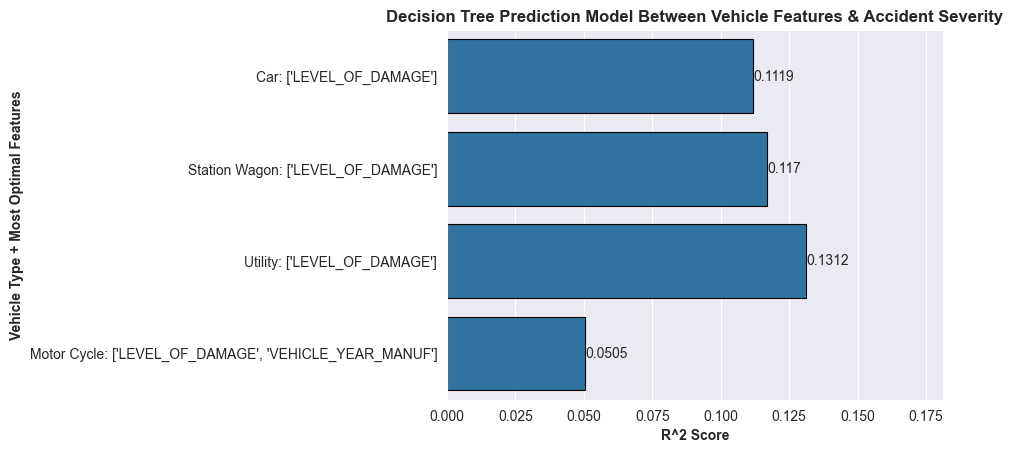

In [8]:


# Plotting out the R^2 scores, features and results
# sns is so much easier and nicer looking than matplotlib
barplot = sns.barplot(x=dec_tree_values, y=dec_tree_features, edgecolor="black", linewidth=0.8)

plt.bar_label(barplot.containers[0], labels=np.round(dec_tree_values, 4))

plt.xlim(0, max(dec_tree_values) + 0.05)
plt.xlabel("R^2 Score", fontweight="bold")
plt.ylabel("Vehicle Type + Most Optimal Features", fontweight="bold")
plt.title("Decision Tree Prediction Model Between Vehicle Features & Accident Severity", fontweight="bold")


Text(0, 0.5, 'Frequency')

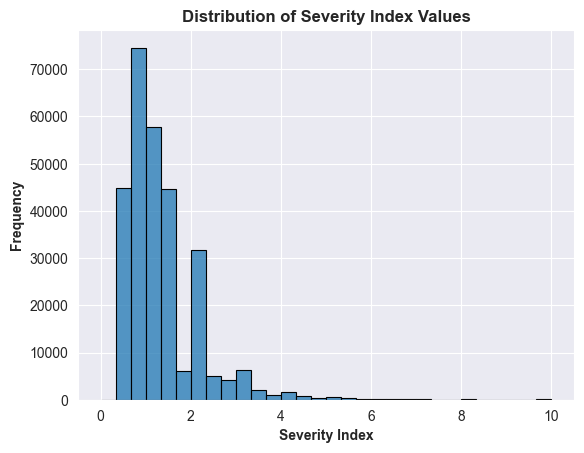

In [9]:
# Exploratory data analysis to explain

# Finding out why the R^2 values are relatively low

# Basically what we see here is heavy weighting for low severity accidents, so prediction model doesn't have much data for high severity
hist = sns.histplot(vehicle_dsev['SEVERITY_INDEX'], bins=30, edgecolor="black", linewidth=0.8)
plt.title("Distribution of Severity Index Values", fontweight="bold")
plt.xlabel("Severity Index", fontweight="bold")
plt.ylabel("Frequency", fontweight="bold")




Text(0.5, 0, 'Level Of Damage')

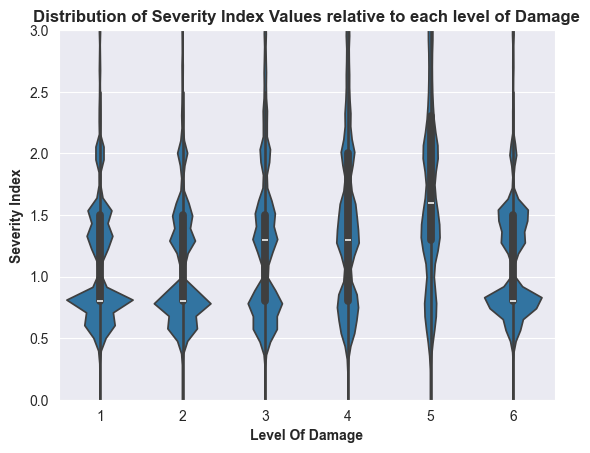

In [10]:

# Violin plot plots density of level of damage to severity index
# Essentially takes it as a proportion of how many data points there are, bypassing our skew issue
# However seing the high densities at we can conclude at this stage that there is no real association between
# Dmg level and severity
sns.violinplot(data=vehicle_dsev, x='LEVEL_OF_DAMAGE', y='SEVERITY_INDEX')
plt.ylim(0, 3)
plt.title("Distribution of Severity Index Values relative to each level of Damage", fontweight="bold")
plt.ylabel("Severity Index", fontweight="bold")
plt.xlabel("Level Of Damage", fontweight="bold")


In [11]:
# Graph to figure out the safest car barnd

# Filter out so it's only cars and station wagons (what most of the popualtion drives)
cars = merged_va[
    ((merged_va['VEHICLE_TYPE'] == 1) | (merged_va['VEHICLE_TYPE'] == 2)) & (merged_va['VEHICLE_MAKE'] != "UNKN") & (
        merged_va['VEHICLE_MAKE'].notnull())]
print(cars)

# Only allowing car brands that have over 1000 recorded accidents
car_brand_count = cars['VEHICLE_MAKE'].value_counts()
filtered_brands = car_brand_count[car_brand_count > 1000].index
cars = cars[cars['VEHICLE_MAKE'].isin(filtered_brands)]

# Group by vehicle make and take mean of the severity index for each and then sort our values
brand_vehicle_severity = cars.groupby('VEHICLE_MAKE')['SEVERITY_INDEX'].mean().sort_values()
print(brand_vehicle_severity)



         ACCIDENT_NO VEHICLE_ID  VEHICLE_YEAR_MANUF  VEHICLE_DCA_CODE  \
0       T20120000009          A              1996.0               1.0   
1       T20120000012          A              2002.0               1.0   
2       T20120000012          B              1988.0               2.0   
3       T20120000013          A              1997.0               1.0   
4       T20120000013          B              2010.0               2.0   
...              ...        ...                 ...               ...   
325879  T20250000783          D              2010.0               8.0   
325884  T20250001671          A              2015.0               2.0   
325886  T20250001949          A              2010.0               1.0   
325887  T20250002210          A              2021.0               1.0   
325888  T20250002210          B              2013.0               2.0   

       INITIAL_DIRECTION  ROAD_SURFACE_TYPE ROAD_SURFACE_TYPE_DESC REG_STATE  \
0                      E                1.0

In [12]:
top_3_safest_values = brand_vehicle_severity.head(3).tolist()
top_3_safest_names = brand_vehicle_severity.head(3).index.tolist()
bot_3_safest_values = brand_vehicle_severity.tail(3).tolist()
bot_3_safest_names = brand_vehicle_severity.tail(3).index.tolist()
print(top_3_safest_values, top_3_safest_names, bot_3_safest_values, bot_3_safest_names)


[1.228962962962963, 1.2538490495012233, 1.2558024691358025] ['LEXUS', 'MERC B', 'VOLVO'] [1.328827160493827, 1.3452830188679246, 1.3561725115125751] ['MITSUB', 'FORD', 'HOLDEN']


Text(0.5, 1.0, 'Safest 3 Brands In Average Accident Severity (Lower Score is safer)')

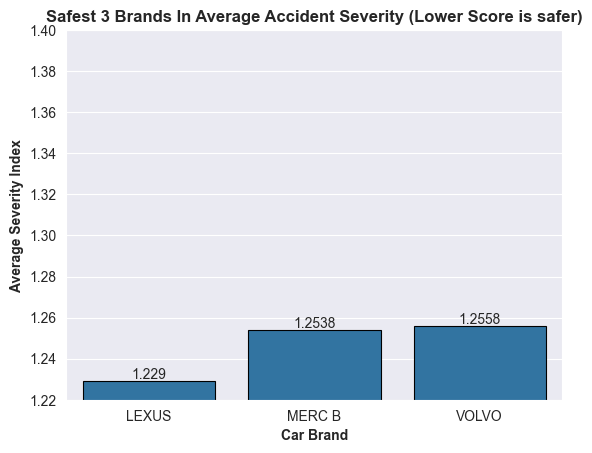

In [13]:



barplot = sns.barplot(x=top_3_safest_names, y=top_3_safest_values, edgecolor="black", linewidth=0.8)

barplot.bar_label(barplot.containers[0], labels=np.round(top_3_safest_values, 4))

plt.ylim(1.22, 1.40)
plt.xlabel("Car Brand", fontweight="bold")
plt.ylabel("Average Severity Index", fontweight="bold")
plt.title("Safest 3 Brands In Average Accident Severity (Lower Score is safer)", fontweight="bold")


Text(0.5, 1.0, 'Least safe 3 Brands In Average Accident Severity (Lower Score is safer)')

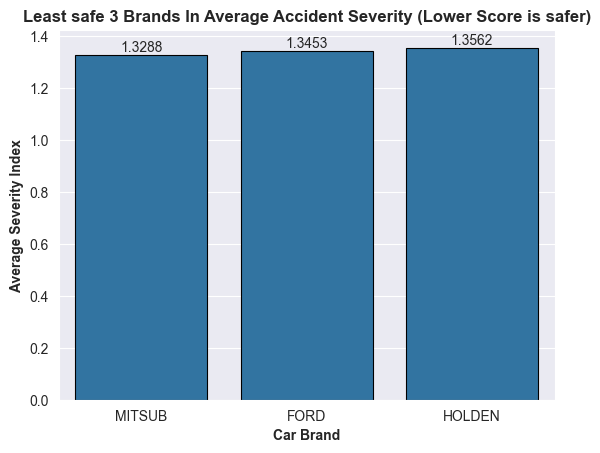

In [14]:
barplot = sns.barplot(x=bot_3_safest_names, y=bot_3_safest_values, edgecolor="black", linewidth=0.8)

plt.bar_label(barplot.containers[0], labels=np.round(bot_3_safest_values, 4))

plt.xlabel("Car Brand", fontweight="bold")
plt.ylabel("Average Severity Index", fontweight="bold")
plt.title("Least safe 3 Brands In Average Accident Severity (Lower Score is safer)", fontweight="bold")


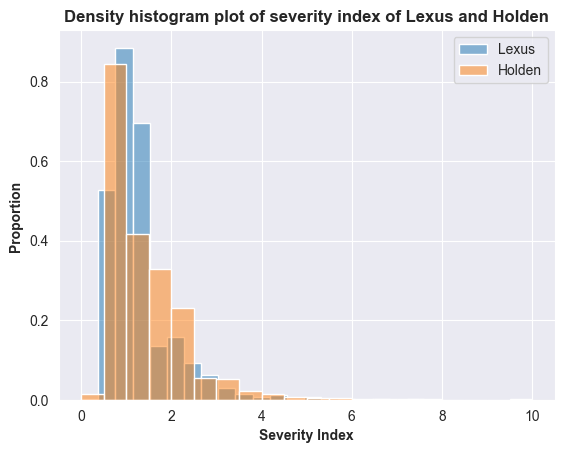

In [15]:
# EDA for this part

# Comparing lexus vs holden distribution of crashes
# Mean supports in this case as relative to frequency,
lexus_data = cars[cars['VEHICLE_MAKE'] == 'LEXUS']
bob1 = sns.histplot(lexus_data['SEVERITY_INDEX'], bins=20, stat="density", alpha=0.5, label="Lexus")

holden_data = cars[cars['VEHICLE_MAKE'] == 'HOLDEN']
bob2 = sns.histplot(holden_data['SEVERITY_INDEX'], bins=20, stat="density", alpha=0.5, label="Holden")

plt.xlabel("Severity Index", fontweight="bold")
plt.ylabel("Proportion ", fontweight="bold")
plt.title("Density histogram plot of severity index of Lexus and Holden", fontweight="bold")
plt.legend()


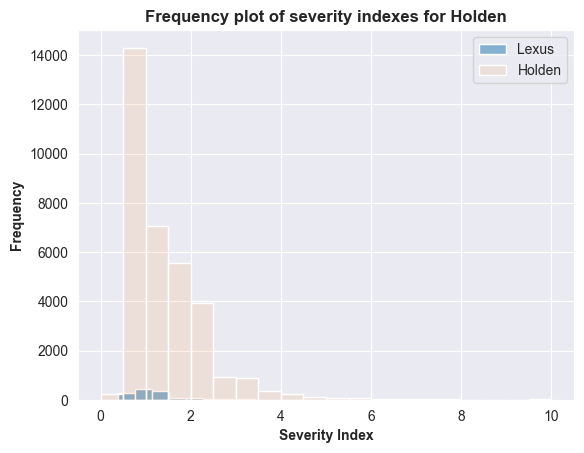

In [16]:

# However we compare the sample sizes of holden and lexus to realise there are a lot less lexuses on the road
# Hard to conclude an association when there is simply less of them on the road implying a lower probability
# Of them getting into a crash??

plt.xlabel("Severity Index", fontweight="bold")
plt.ylabel("Frequency", fontweight="bold")
plt.title("Frequency plot of severity indexes for Holden", fontweight="bold")

lexus_data = cars[cars['VEHICLE_MAKE'] == 'LEXUS']
bob1 = sns.histplot(lexus_data['SEVERITY_INDEX'], bins=20, alpha=0.5, label="Lexus")

holden_data = cars[cars['VEHICLE_MAKE'] == 'HOLDEN']
bob2 = sns.histplot(holden_data['SEVERITY_INDEX'], bins=20, alpha=0.1, label="Holden")

plt.legend()

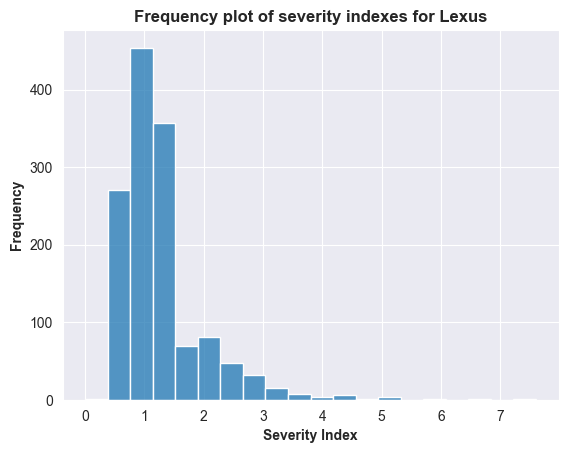

In [17]:
plt.xlabel("Severity Index", fontweight="bold")
plt.ylabel("Frequency", fontweight="bold")
plt.title("Frequency plot of severity indexes for Lexus", fontweight="bold")

lexus_data = cars[cars['VEHICLE_MAKE'] == 'LEXUS']
bob1 = sns.histplot(lexus_data['SEVERITY_INDEX'], bins=20)

Text(0.5, 1.0, 'Safest 3 Brands In Average Accident Severity (Lower Score is safer) (MEDIAN)')

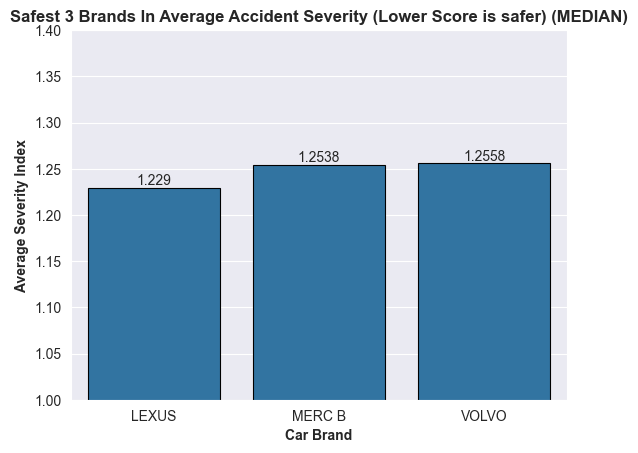

In [18]:
# Hence we further investigation by calculating median which is more rigorous against
# Outliers and inbalanced sample sizes
# Comparing these graphs to the previous ones we can see the patterns and trends are the same
# If mean and median return same results, trends can be seen as more robust, and highlights that the results from the mean
# were not influenced by outliers

brand_vehicle_severity = cars.groupby('VEHICLE_MAKE')['SEVERITY_INDEX'].mean().sort_values()

top_3_safest_values = brand_vehicle_severity.head(3).tolist()
top_3_safest_names = brand_vehicle_severity.head(3).index.tolist()
bot_3_safest_values = brand_vehicle_severity.tail(3).tolist()
bot_3_safest_names = brand_vehicle_severity.tail(3).index.tolist()

barplot = sns.barplot(x=top_3_safest_names, y=top_3_safest_values, edgecolor="black", linewidth=0.8)
barplot.bar_label(barplot.containers[0], labels=np.round(top_3_safest_values, 4))

plt.ylim(1, 1.4)
plt.xlabel("Car Brand", fontweight="bold")
plt.ylabel("Average Severity Index", fontweight="bold")
plt.title("Safest 3 Brands In Average Accident Severity (Lower Score is safer) (MEDIAN)", fontweight="bold")

Text(0.5, 1.0, 'Least safe 3 Brands In Average Accident Severity (Lower Score is safer) (MEDIAN)')

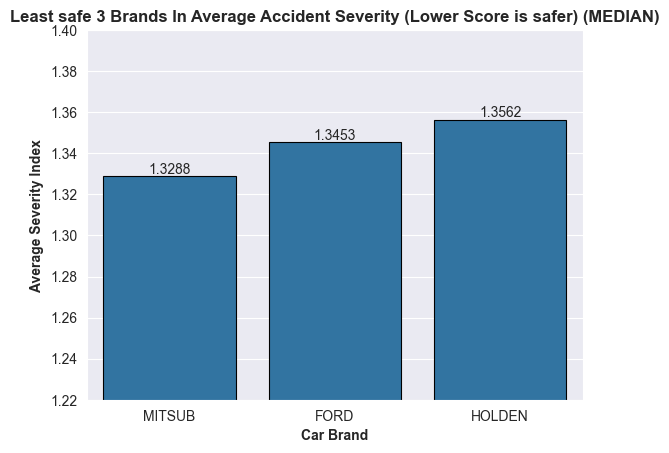

In [19]:
barplot = sns.barplot(x=bot_3_safest_names, y=bot_3_safest_values, edgecolor="black", linewidth=0.8)
plt.bar_label(barplot.containers[0], labels=np.round(bot_3_safest_values, 4))

plt.ylim(1.22, 1.40)
plt.xlabel("Car Brand", fontweight="bold")
plt.ylabel("Average Severity Index", fontweight="bold")
plt.title("Least safe 3 Brands In Average Accident Severity (Lower Score is safer) (MEDIAN)", fontweight="bold")